In [951]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
from pandas import DataFrame, Series
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [952]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [953]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [954]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.456,0.428,0.401,0.436
1,8480039,Martin Necas,Necas,C,CAR,81,R,0.610,0.620,0.602,0.597
2,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.453,0.448,0.430,0.436
3,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.434,0.416,0.411,0.431
4,8482259,Bobby McMann,McMann,C,TOR,56,L,0.518,0.511,0.509,0.530
...,...,...,...,...,...,...,...,...,...,...,...
466,8481553,Bobby Brink,Brink,R,PHI,57,R,0.480,0.489,0.508,0.502
467,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,R,0.518,0.490,0.484,0.509
468,8478400,Colin White,White,C,"PIT,MTL",28,R,0.471,0.500,0.504,0.482
469,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,L,0.517,0.516,0.537,0.542


In [955]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [956]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [957]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,81,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,0,0,0
...,...,...,...,...,...,...,...,...,...
466,8481553,Bobby Brink,Brink,R,PHI,57,2,0,0
467,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,3,1,1
468,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,0,0,1
469,8478400,Colin White,White,C,"PIT,MTL",28,0,0,0


In [958]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [959]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [960]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose,gameWinningGoals,otGoals,shGoals
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,45.6,42.8,40.1,43.6,1,0,0
1,8480039,Martin Necas,Necas,C,CAR,81,R,61.0,62.0,60.2,59.7,3,2,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.3,44.8,43.0,43.6,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.4,41.6,41.1,43.1,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,L,51.8,51.1,50.9,53.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,8481553,Bobby Brink,Brink,R,PHI,57,R,48.0,48.9,50.8,50.2,2,0,0
467,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,R,51.8,49.0,48.4,50.9,3,1,1
468,8478400,Colin White,White,C,PIT,28,R,47.1,50.0,50.4,48.2,0,0,0
469,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,L,51.7,51.6,53.7,54.2,0,0,1


In [961]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,471.000000,471.000000,471.000000,471.000000
mean,49.341401,49.390021,49.447134,49.346921
std,4.854702,5.317415,5.461438,4.934165
min,35.700000,34.100000,34.700000,34.400000
50%,49.800000,49.700000,49.500000,49.700000
75%,52.500000,52.900000,53.400000,52.700000
80%,53.200000,53.800000,54.400000,53.300000
90%,55.300000,56.200000,56.200000,55.300000
max,62.500000,62.100000,63.200000,61.700000


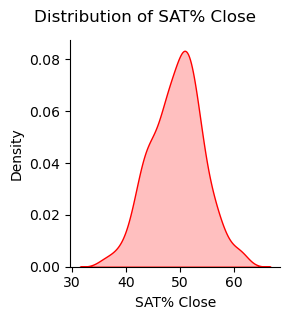

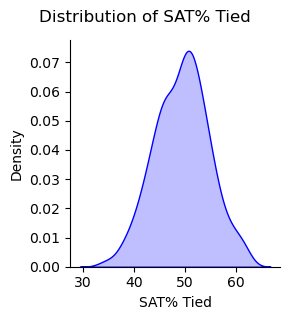

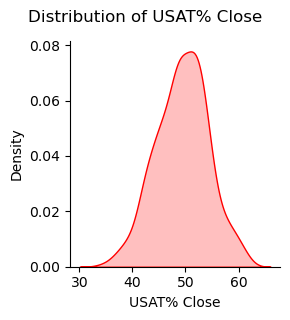

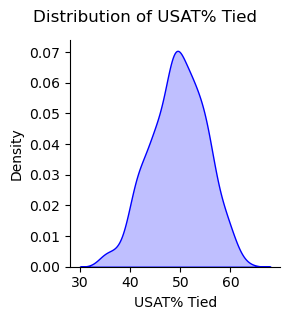

In [962]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageClose', fill=True, color='red')
satClose.fig.suptitle("Distribution of SAT% Close", y = 1.05)
satClose.set_xlabels("SAT% Close")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageTied', fill=True, color='blue')
satTied.fig.suptitle("Distribution of SAT% Tied", y = 1.05)
satTied.set_xlabels("SAT% Tied")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageClose', fill=True, color='red')
usatClose.fig.suptitle("Distribution of USAT% Close", y = 1.05)
usatClose.set_xlabels("USAT% Close")

usatTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageTied', fill=True, color='blue')
usatTied.fig.suptitle("Distribution of USAT% Tied", y = 1.05)
usatTied.set_xlabels("USAT% Tied")

In [963]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,471.000000,471.000000,471.000000
mean,2.222930,0.318471,0.447983
std,2.330004,0.678279,0.848623
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,12.000000,3.000000,6.000000


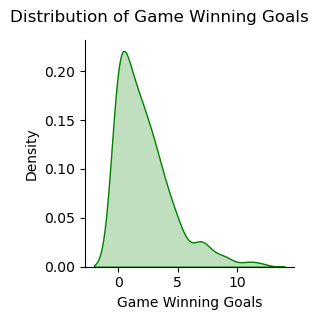

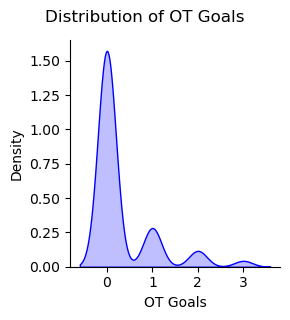

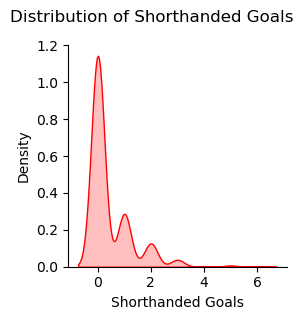

In [964]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'gameWinningGoals', fill=True, color='green')
satClose.fig.suptitle("Distribution of Game Winning Goals", y = 1.05)
satClose.set_xlabels("Game Winning Goals")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'otGoals', fill=True, color='blue')
satTied.fig.suptitle("Distribution of OT Goals", y = 1.05)
satTied.set_xlabels("OT Goals")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'shGoals', fill=True, color='red')
usatClose.fig.suptitle("Distribution of Shorthanded Goals", y = 1.05)
usatClose.set_xlabels("Shorthanded Goals")